In [962]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [946]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [947]:
NAME = "classifier_143features_100x100x100_0.001lr_50e_0.5dropout_64bs"
MODEL_PATH = "models/" + NAME + ".pth"

## Dataset Loader

In [963]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os

class StockDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.y = df['Label'].to_numpy().astype(int)
        self.features = df.drop(["Company", "Date", "Target", "Label"], axis=1).to_numpy().astype('float32')

    def __getitem__(self, index):
        features = self.features[index]
        label = self.y[index]
        
        out_label = 0
        
        if label <= 2:
            out_label = 0
        elif label <= 5:
            out_label = 1
        else:
            out_label = 2
        
        binary_label = 1
        
        if label >= 5:
            binary_label = 2
        
        return features, label

    def __len__(self):
        return self.y.shape[0]

In [951]:
BATCH_SIZE = 64

In [1063]:
train_dataset = StockDataset(csv_path='train_normalized.csv')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)


valid_dataset = StockDataset(csv_path='val_normalized.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)

test_dataset = StockDataset(csv_path='test_normalized.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

The cell below just checks if the dataset can be loaded correctly.

In [1066]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        num_features = x.shape[1]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


In [1065]:
num_features = 143
classes = 9

If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [1067]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_classes, dropout):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)        
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)

        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
    def forward(self, x):    
        out = self.linear_1(x)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        out = self.linear_2(out)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        out = self.linear_3(out)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas
        
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [1068]:
model = MLP(num_features=num_features,
            num_hidden_1=200,
            num_hidden_2=300,
            num_hidden_3=100,
            num_classes=classes,
            dropout=0.4)

model = model.to(DEVICE)

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.0)

model.apply(init_weights)

MLP(
  (linear_1): Linear(in_features=143, out_features=200, bias=True)
  (linear_2): Linear(in_features=200, out_features=300, bias=True)
  (linear_3): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=100, out_features=9, bias=True)
)

In [958]:
def compute_corr_accuracy_and_loss(model, data_loader, device, target_val):
    correct_pred, num_examples = 0, 0
    c2, n2 = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
            
        for p in range(len(targets)):
            if predicted_labels[p].item() == target_val:
                n2 += 1
                if targets[p].item() == predicted_labels[p].item():
                    c2 += 1
                    
            if targets[p].item() == target_val:
                num_examples += 1
                if targets[p].item() == predicted_labels[p].item():
                    correct_pred += 1
                
                
    return 1.0 * correct_pred/num_examples * 100, 1.0 * c2/n2 * 100

def compute_corrlist_accuracy_and_loss(model, data_loader, device, target_list):
    correct_pred, num_examples = 0, 0
    c2, n2 = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
            
        for p in range(len(targets)):
            if predicted_labels[p].item() in target_list:
                n2 += 1
                if targets[p].item() in target_list:
                    c2 += 1
                    
            if targets[p].item() in target_list:
                num_examples += 1
                if predicted_labels[p].item() in target_list:
                    correct_pred += 1
                
                
    return 1.0 * correct_pred/num_examples * 100, 1.0 * c2/n2 * 100

def compute_grouped_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
        
        for i in range(len(targets)):
            num_examples += 1
            c = 0
            if targets[i].item() in [0, 1, 2] and predicted_labels[i] in [0, 1, 2]:
                c = 1
            elif targets[i].item() in [3, 4] and predicted_labels[i] in [3, 4]:
                c = 1  
            elif targets[i].item() in [5, 6, 7, 8] and predicted_labels[i] in [5, 6, 7, 8]:
                c = 1 
            if abs(targets[i].item() - predicted_labels[i]) <= 1:
                c = 1
            correct_pred += c
                
    return 1.0 * correct_pred/num_examples * 100, cross_entropy/num_examples

In [959]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [960]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 50 # Please feel free to change
############################################################

In [961]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, num_features).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features.float())
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 200:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/978 | Cost: 2.1968
Epoch: 001/050 | Batch 200/978 | Cost: 2.2127
Epoch: 001/050 | Batch 400/978 | Cost: 2.1872
Epoch: 001/050 | Batch 600/978 | Cost: 2.1957
Epoch: 001/050 | Batch 800/978 | Cost: 2.1922
Epoch: 001/050 Train Acc.: 13.93% | Validation Acc.: 12.66%
Time elapsed: 0.05 min
Epoch: 002/050 | Batch 000/978 | Cost: 2.1851
Epoch: 002/050 | Batch 200/978 | Cost: 2.1931
Epoch: 002/050 | Batch 400/978 | Cost: 2.1687
Epoch: 002/050 | Batch 600/978 | Cost: 2.1300
Epoch: 002/050 | Batch 800/978 | Cost: 2.1492
Epoch: 002/050 Train Acc.: 14.50% | Validation Acc.: 13.66%
Time elapsed: 0.11 min
Epoch: 003/050 | Batch 000/978 | Cost: 2.1587
Epoch: 003/050 | Batch 200/978 | Cost: 2.1810
Epoch: 003/050 | Batch 400/978 | Cost: 2.2011
Epoch: 003/050 | Batch 600/978 | Cost: 2.1529
Epoch: 003/050 | Batch 800/978 | Cost: 2.2038
Epoch: 003/050 Train Acc.: 15.47% | Validation Acc.: 15.63%
Time elapsed: 0.16 min
Epoch: 004/050 | Batch 000/978 | Cost: 2.1615
Epoch: 004/050 


#### Evaluation (No Need To Change Any Code in This Section!)

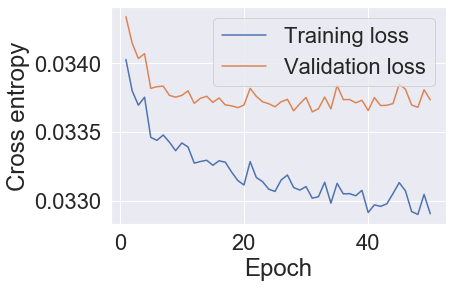

In [964]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

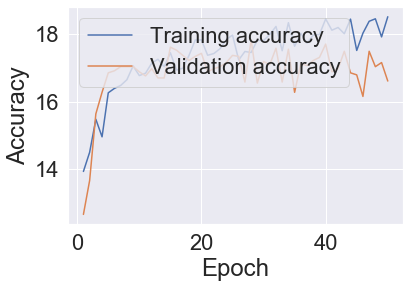

In [965]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [981]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 19.52%


In [982]:
# Manually inspecting some of the predictions
num = 0

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (x, y) in enumerate(test_loader):
        if i == num:
            logits, probas = model(x)
            pred = np.argmax(probas, axis=1)
            print(pred)
            print(y)

tensor([7, 7, 5, 7, 7, 6, 2, 1, 1, 2, 1, 0, 1, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0,
        0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 8, 1, 8, 8, 8,
        7, 8, 1, 7, 7, 1, 1, 7, 5, 5, 5, 5, 5, 2, 5, 4])
tensor([2, 5, 5, 6, 0, 5, 0, 0, 1, 1, 1, 2, 0, 2, 1, 1, 5, 2, 1, 3, 1, 2, 0, 0,
        3, 0, 3, 0, 8, 0, 3, 2, 2, 2, 3, 6, 5, 6, 7, 7, 0, 7, 0, 5, 2, 5, 8, 4,
        2, 6, 8, 7, 2, 4, 1, 7, 7, 6, 0, 8, 4, 7, 8, 4])
False


In [1071]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [1072]:
def convertLabels(label):
    # 0 - 4 : 0
    # 5 - 8: 1
    bounds = [0, 4, 4, 8]
    if label >= bounds[0] and label <= bounds[1]:
        return 0
    elif label <= bounds[3]:
        return 2
    return -1

In [1073]:
loader = test_loader
target_labels = []
pred_labels = []

target_labels_3 = []
pred_labels_3 = []
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (features, targets) in enumerate(loader):
        logits, probas = model(features)
        pred = np.argmax(probas, axis=1)

        for j in range(len(pred)):
            target_labels.append(targets[j].item())
            pred_labels.append(pred[j].item())
            target_labels_3.append(convertLabels(targets[j].item()))
            pred_labels_3.append(convertLabels(pred[j].item()))

In [1074]:
# 9 labels
print(f1_score(target_labels, pred_labels, average='micro'))
f1_score(target_labels, pred_labels, average=None)

0.1035674535762404


array([0.11855104, 0.        , 0.0359874 , 0.01613717, 0.        ,
       0.097313  , 0.14944194, 0.        , 0.16118175])

In [1076]:
confusion_matrix(target_labels, pred_labels), 

(array([[ 270,    0,   31,    5,    0,   75, 1771,    0,  563],
        [ 228,    0,   32,    7,    0,  106, 1202,    0,  436],
        [ 203,    0,   40,   18,    0,  119, 1167,    0,  382],
        [ 191,    0,   39,   16,    0,  125, 1120,    0,  378],
        [ 204,    0,   43,   20,    0,  141, 1207,    0,  391],
        [ 203,    0,   48,   22,    0,  134, 1013,    0,  378],
        [ 205,    0,   33,    9,    0,  115,  877,    0,  404],
        [ 176,    0,   18,    9,    0,  100,  812,    0,  409],
        [ 160,    1,   10,    8,    0,   41,  925,    0,  431]]),)

In [1075]:
# 3 labels
print(f1_score(target_labels_3, pred_labels_3, average='micro'))
f1_score(target_labels_3, pred_labels_3, average=None)

0.4092320309296467


array([0.21081462, 0.52792211])

In [1077]:
confusion_matrix(target_labels_3, pred_labels_3)

array([[1347, 9183],
       [ 902, 5639]])

In [347]:
l = pred_labels
counts = {}

for i in l:
    if i in counts:
        counts[i] += 1
    else:
        counts[i] = 0

print(counts)

{8: 3613, 6: 2062, 1: 841, 0: 5070, 7: 1921, 4: 3496, 5: 37, 3: 23}


In [348]:
# torch.save(model, MODEL_PATH)

In [349]:
## Multiple model inference

In [1078]:
import glob
model_files = glob.glob("models/*.pth")
models = []

In [1079]:
for m in model_files:
    models.append(torch.load(m))

In [1080]:
model_files

['models/classifier_143features_200x300x100_0.001lr_50e_0.4dropout_64bs_orthogonal.pth',
 'models/classifier_143features_50x75x25_0.001lr_50e_0.3dropout_64bs_xavier_norm.pth',
 'models/classifier_143features_125x250x100_0.001lr_50e_0.2dropout_64bs_xavier.pth',
 'models/classifier_143features_75x100x50_0.001lr_100e_0.3dropout_128bs_sparse_.pth',
 'models/classifier_143features_75x100x50_0.001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier_143features_150x300x100_0.001lr_100e_0.5dropout_128bs_orthogonal.pth',
 'models/classifier_143features_200x300x200_0.0001lr_50e_0.4dropout_64bs_kaiming_norm.pth',
 'models/classifier_143features_125x250x100_0.001lr_50e_0.2dropout_64bs_xavier_norm.pth',
 'models/classifier_143features_50x75x25_0.001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier_143features_200x300x200_0.001lr_50e_0.3dropout_64bs_kaiming_norm.pth',
 'models/classifier_143features_75x150x50_0.0001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier

In [1081]:
results = []

for model in models:
    loader = test_loader
    target_labels = []
    pred_labels = []

    target_labels_3 = []
    pred_labels_3 = []
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        for i, (features, targets) in enumerate(loader):
            logits, probas = model(features)
            pred = np.argmax(probas, axis=1)

            for j in range(len(pred)):
                target_labels.append(targets[j].item())
                pred_labels.append(pred[j].item())
                target_labels_3.append(convertLabels(targets[j].item()))
                pred_labels_3.append(convertLabels(pred[j].item()))
                
    model_results = dict()
    model_results["targets"] = target_labels
    model_results["predictions"] = pred_labels
    model_results["targets_3"] = target_labels_3
    model_results["predictions_3"] = pred_labels_3
    
    model_results["f1"] = f1_score(target_labels, pred_labels, average=None)
    
    results.append(model_results)

In [1083]:
def calculateProb(results, num_labels):
    probabilities = np.zeros(num_labels * len(results[0]["targets"])).reshape(-1, 9)
    # Iterate row by row over each prediction and calculate aggregated probabilities
    for i in range(len(results[0]["targets"])):
        for j in range(len(results)):
            prediction = results[j]["predictions"][i]
            probabilities[i][prediction] += results[j]["f1"][prediction]
    return probabilities

In [1088]:
test_pred_prob = calculateProb(results, 9)

In [1090]:
def calculateFinalPredictions(probabilities):
    pred = []
    prob = []
    prob_diff = []
    for i in range(len(probabilities)):
        # 0 - 4: Sell
        # 5 - 8 : Buy
        sell_prob = probabilities[i][0] + probabilities[i][1] + probabilities[i][2] + probabilities[i][3] + probabilities[i][4]
        buy_prob = probabilities[i][5] + probabilities[i][6] + probabilities[i][7] + probabilities[i][8]
        
        if sell_prob > buy_prob:
            pred.append(0)
            prob.append(sell_prob)
        else:
            pred.append(1)
            prob.append(buy_prob)
        prob_diff.append(abs(sell_prob - buy_prob))
    return pred, prob, prob_diff

In [1091]:
decisions, prob, diff = calculateFinalPredictions(test_pred_prob)

In [1092]:
def convertLabelToBuySell(targets):
    output = []
    
    for i in targets:
        if i <= 4:
            output.append(0)
        else:
            output.append(1)
    return output

In [1093]:
actual = convertLabelToBuySell(results[0]["targets"])

In [1094]:
f1_score(actual, decisions, average=None)

array([0.64583835, 0.44969706])

In [1095]:
confusion_matrix(actual, decisions)

array([[6708, 3822],
       [3535, 3006]])

In [1096]:
# Convert to list of dicts to make sorting easier
l = []

for i in range(len(decisions)):
    temp = dict()
    temp["Prediction"] = decisions[i]
    temp["Actual"] = actual[i]
    temp["Probability"] = prob[i]
    temp["Diff"] = diff[i]
    l.append(temp)

In [1097]:
sorted_pred = sorted(l, key=lambda k: k['Diff'], reverse=True) 

In [1098]:
def calculateSortedAccuracy(sorted_pred, num):
    counter = 0
    correct = 0
    total = 0

    counter_max = num

    for item in sorted_pred:
        if item['Prediction'] == 0:
            total += 1
            counter += 1
            if item["Actual"] == 0:
                correct += 1
        if counter >= counter_max:
            break
    
    sell_acuracy = correct/total * 100
    sell_total = total
    sell_correct = correct
    
    counter = 0
    correct = 0
    total = 0

    counter_max = num

    for item in sorted_pred:
        if item['Prediction'] == 1:
            total += 1
            counter += 1
            if item["Actual"] == 1:
                correct += 1
        if counter >= counter_max:
            break
    
    buy_acuracy = correct/total * 100
    buy_total = total
    buy_correct = correct
    
    overall_correct = buy_correct + sell_correct
    overall_total = buy_total + sell_total
    overall_accuracy = overall_correct/overall_total * 100
    
    print("Top", num, "stocks")
    print("Overall accuracy: ", overall_accuracy, "%")
    print("Buy accuracy: ", buy_acuracy, "%")
    print("Sell accuracy: ", sell_acuracy, "%")

In [1099]:
calculateSortedAccuracy(sorted_pred, 1000)

Top 1000 stocks
Overall accuracy:  57.65 %
Buy accuracy:  46.2 %
Sell accuracy:  69.1 %


In [1100]:
calculateSortedAccuracy(sorted_pred, 100)

Top 100 stocks
Overall accuracy:  56.99999999999999 %
Buy accuracy:  42.0 %
Sell accuracy:  72.0 %


In [1101]:
calculateSortedAccuracy(sorted_pred, 50)

Top 50 stocks
Overall accuracy:  59.0 %
Buy accuracy:  42.0 %
Sell accuracy:  76.0 %


In [1102]:
calculateSortedAccuracy(sorted_pred, 20)

Top 20 stocks
Overall accuracy:  62.5 %
Buy accuracy:  50.0 %
Sell accuracy:  75.0 %


In [1103]:
calculateSortedAccuracy(sorted_pred, 10)

Top 10 stocks
Overall accuracy:  70.0 %
Buy accuracy:  50.0 %
Sell accuracy:  90.0 %


In [1104]:
test = pd.read_csv("test_raw.csv")

In [1105]:
long_stocks = test[test["Label"] >= 5]
print("Stats for long stocks in test set")
((long_stocks["Target"] - long_stocks["Stock Price"])/long_stocks["Stock Price"] * 100).describe()

Stats for long stocks in test set


count    6541.000000
mean       17.182326
std        14.331726
min         4.300567
25%         7.867133
50%        12.500000
75%        21.134180
max        99.884626
dtype: float64

In [1106]:
short_stocks = test[test["Label"] < 5]
print("Stats for short stocks in test set")
((short_stocks["Target"] - short_stocks["Stock Price"])/short_stocks["Stock Price"] * 100).describe()

Stats for short stocks in test set


count    10530.000000
mean       -10.481453
std         14.167806
min        -95.954887
25%        -15.924470
50%         -6.262623
75%         -0.412018
max          4.298844
dtype: float64